In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#카카오톡
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/Kako035720.KS.csv' 

df = pd.read_csv(dataset_filepath, index_col='Date',parse_dates=True) 
ts1 = df['Close']

ts1=ts1.interpolate(method='time')
ts_log=np.log(ts1)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

ts1.tail(100)

Date
2020-03-23    143500.0
2020-03-24    154500.0
2020-03-25    154500.0
2020-03-26    150500.0
2020-03-27    152500.0
                ...   
2020-08-07    353000.0
2020-08-10    356000.0
2020-08-11    352500.0
2020-08-12    354000.0
2020-08-13    358500.0
Name: Close, Length: 100, dtype: float64

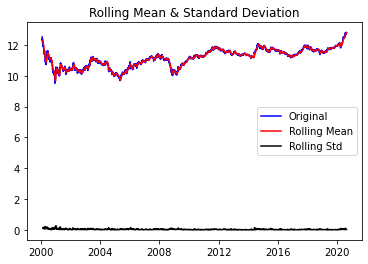

Results of Dickey-Fuller Test:
Test Statistic                   -1.678667
p-value                           0.442136
#Lags Used                        5.000000
Number of Observations Used    5153.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


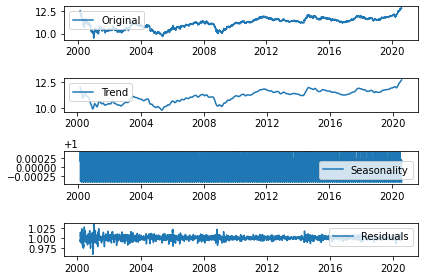

In [59]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [62]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.770623e+01
p-value                        3.518761e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.095000e+03
Critical Value (1%)           -3.431634e+00
Critical Value (5%)           -2.862107e+00
Critical Value (10%)          -2.567072e+00
dtype: float64


In [156]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)],ts_log[int(len(ts_log)*0.9):]

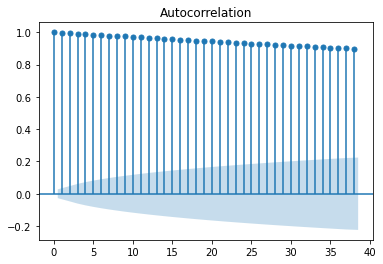

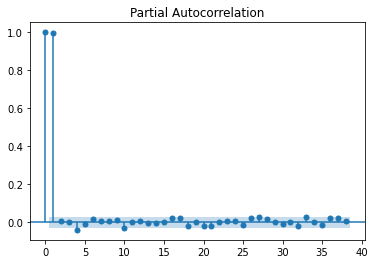

In [157]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -31.818347
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    5153.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


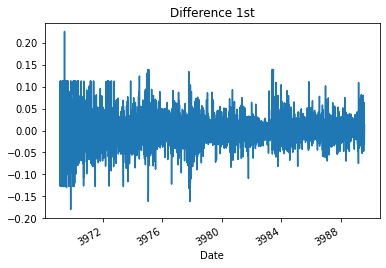

In [158]:
# d값 구하기
#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.776239
p-value                           0.000000
#Lags Used                       31.000000
Number of Observations Used    5125.000000
Critical Value (1%)              -3.431627
Critical Value (5%)              -2.862104
Critical Value (10%)             -2.567070
dtype: float64


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


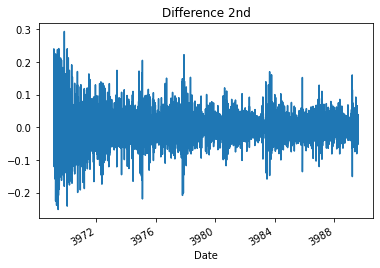

In [159]:
#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [164]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1,1,10))  #p,d,q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4642
Model:                ARIMA(1, 1, 10)   Log Likelihood                9150.878
Method:                       css-mle   S.D. of innovations              0.034
Date:                Thu, 13 Aug 2020   AIC                         -18275.756
Time:                        16:56:56   BIC                         -18191.998
Sample:                             1   HQIC                        -18246.289
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0002      0.001     -0.345      0.730      -0.001       0.001
ar.L1.D.Close      0.6370      1.115      0.572      0.568      -1.548       2.821
ma.L1.D.Close     -0.6223      1.115

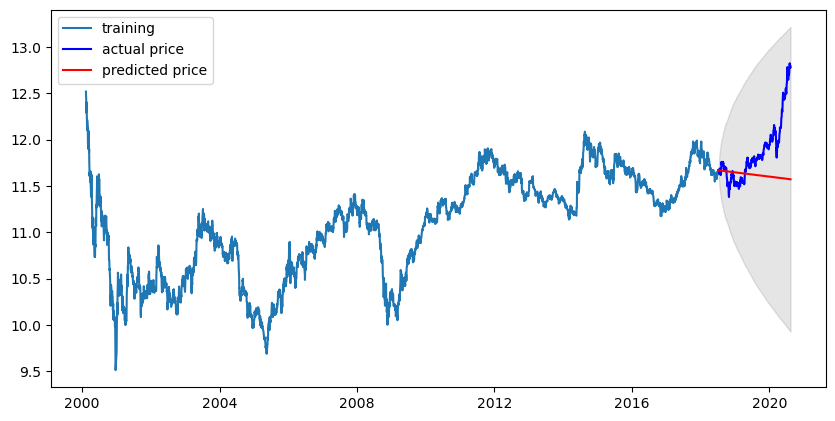

In [165]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [166]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5734308191.281739
MAE:  46126.623108628504
RMSE:  75725.21502961704
MAPE: 23.30%


### 카카오의 같은 경우, d 값은 1으로 고정하고, p,q 값을 변경했을 때, Mape  정확도가 크게 변하지 않았다. q의 경우 10~20까지 변경해 보았는데, 연산량이 많아 시간이 오래 걸렸으며, 정확도는 23% 부근에서 머물러 있었다.

### 하이닉스와 네이버의 경우에는 약 13%, 11%의 정확도를 보였으며, 역시나 p ,q 의 값은 변경했을 때, 1~2 % 범위 내로 움직이는 것을 확인할 수 있었다.

# 결론 : p,q, 값이 변경되는 것이 정확도에 어떤 영향을 주는지 찾기 힘들었다. 삼성전자나 Microsoft 와 같이 주가가 일정한 패턴을 유지했을 때,
 -  추세가 일정한 주식데이터를 넣으면 좋은 결과가 나온다.
 - ARIMA 로는 예측하기가 힘들다는 결론...

